In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

In [7]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

spark.read.csv("MsNPC.csv", header = True).createOrReplaceTempView("npcs")
spark.read.csv("MsPlayer.csv", header = True).createOrReplaceTempView("players")
spark.read.csv("MsWeapon.csv", header = True).createOrReplaceTempView("weapons")
spark.read.csv("MsWeaponType.csv", header = True).createOrReplaceTempView("weapon_types")
spark.read.csv("TransactionDetail.csv", header = True).createOrReplaceTempView("transaction_details")
spark.read.csv("TransactionHeader.csv", header = True).createOrReplaceTempView("transaction_headers")

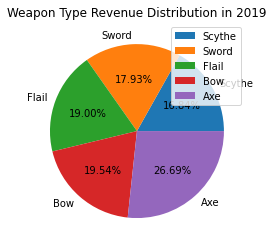

In [ ]:
# a.	Show the percentage of weapon type sold for weapon type that is sold in 2019 using pie plot.
import matplotlib.pyplot as plt

answer1 = spark.sql("""
  select wt.weapontypename, sum(w.weaponprice * td.quantity) as revenue
  from weapon_types wt
    join weapons w on wt.weapontypeid = w.weapontypeid
    join transaction_details td on td.weaponid = w.weaponid
    join transaction_headers th on th.transactionid = td.transactionid
    where year(transactiondate) = 2019
    group by wt.weapontypename, wt.weapontypeid
    order by revenue
""").toPandas()

# display(answer1)
plt.pie(answer1["revenue"], labels=answer1["weapontypename"], autopct="%.2f%%")
plt.legend(
    answer1["weapontypename"],
    loc = "upper right"
)
plt.title("Weapon Type Revenue Distribution in 2019")
plt.show()


Text(0, 0.5, 'PlayerCount')

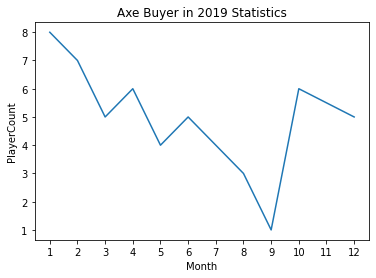

In [ ]:
# b.	Show the total number of players who bought axe weapon type per month in 2019 using line plot. Multiple transaction within the same month will be counted as 1.
import matplotlib.pyplot as plt

answer2 = spark.sql("""
  select count(distinct th.PlayerId) as PlayerCount, month(th.TransactionDate) as Month
  from transaction_headers th
      join transaction_details td on th.transactionid = td.transactionid
      join weapons w on td.weaponid = w.weaponid
      join weapon_types wt on w.weapontypeid = wt.weapontypeid
    where year(th.transactiondate) = 2019
      and wt.weapontypename = 'Axe'
    group by month(th.TransactionDate)
    order by Month
""").toPandas()

plt.plot(answer2["Month"], answer2["PlayerCount"])
plt.xticks(range(1, 13))
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("PlayerCount")




,specialweapon,frequency
0,Storm Breaker,17
1,Extinction,7
2,Nightfall,9


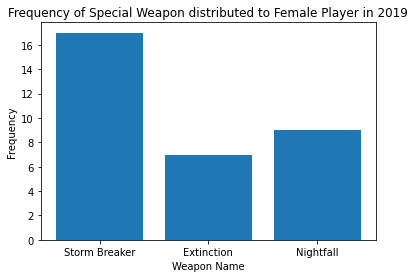

In [ ]:
# c.	Show the frequency of special weapon being distributed to female players in
#  2019 using bar plot. The player will receive special weapon if their monthly spending
#   reached this following condition: 

# Special Weapon	Monthly Spending
# Storm Breaker	1000000 - 1499999
# Nightfall	1500000 – 1999999
# Extinction	> 2000000

answer3 = spark.sql("""
  select specialweapon, count(specialweapon) as frequency
  from
  (
  select 
    p.playerid,
    sum(w.weaponprice * td.quantity) as Spending,
    case
      when sum(w.weaponprice * td.quantity) between 1000000 and 1499999 then 'Storm Breaker'
      when sum(w.weaponprice * td.quantity) between 1500000 and 1999999 then 'Nightfall'
      when sum(w.weaponprice * td.quantity) > 2000000 then 'Extinction'
    end as specialweapon
  from players p
    join transaction_headers th on th.playerid = p.playerid
    join transaction_details td on td.transactionid = th.transactionid
    join weapons w on td.weaponid = w.weaponid
  where playergender = 'Female'
    and year(th.transactiondate) = 2019
  group by p.playerid, month(th.transactiondate)
  ) as sub1
  where specialweapon is not null
  group by sub1.specialweapon
""").toPandas()

display(answer3)
plt.bar(answer3["specialweapon"], answer3["frequency"])
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.show()


Text(0, 0.5, 'Player Count')

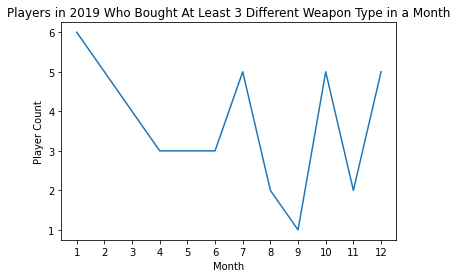

In [ ]:
# d.	Show total number of players per month in 2019 who bought at least 3 different
#  weapon type in a month using line plot.

answer4 = spark.sql("""
  select month, count(playerid) as playercount
  from(
  select p.playerid, month(th.transactiondate) as month, count(distinct w.weapontypeid) as totalType
  from weapons w
  join transaction_details td on td.weaponid = w.weaponid
  join transaction_headers th on th.transactionid = td.transactionid
  join players p on p.playerid = th.playerid
  where year(th.transactiondate) = 2019
  group by p.playerid, month
  having totalType >= 3
  )as sub1
  group by month
  order by month
""").toPandas()

plt.plot(
    answer4["month"],
    answer4["playercount"]
)

plt.xticks(range(1, 13))
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.xlabel("Month")
plt.ylabel("Player Count")




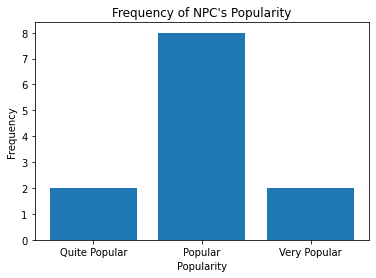

In [ ]:
# e.	Show the frequency of NPC's popularity who has done at least transaction with
#  5 different player using bar plot. The popularity is determined based on the total 
#  income made by the NPC as follows:

# Popularity	Total Income
# Very Popular	>= 15,000,000
# Popular	>= 7,500,000 – 14,999,999
# Quite Popular	>= 2,500,000 – 7,499,999
# Not Popular	< 2,500,000

answer5 = spark.sql("""
  select popularity, count(popularity) as count
  from(
  select th.npcid, 
  sum(w.weaponprice * td.quantity) as spending,
  case
    when sum(w.weaponprice * td.quantity) >= 15000000 then 'Very Popular'
    when sum(w.weaponprice * td.quantity) between 7500000 and 14999999 then 'Popular'
    when sum(w.weaponprice * td.quantity) between 2500000 and 74999999 then 'Quite Popular'
    else 'Not Popular'
  end as popularity
  from transaction_headers th
  join players p on p.playerid = th.playerid
  join transaction_details td on td.transactionid = th.transactionid
  join weapons w on w.weaponid = td.weaponid
  group by th.npcid
  having count(distinct p.playerid) >= 5
  )as sub1
  group by popularity
""").toPandas()


plt.bar(
    answer5["popularity"],
    answer5["count"]
)

plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")

plt.show()

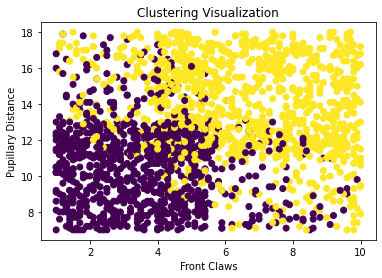

Accuracy: 83.5%


In [8]:
testing = spark.read.csv("BearTesting.csv", header=True, inferSchema=True)
training = spark.read.csv("BearTraining.csv", header=True, inferSchema=True)

columns = ["Front Claws", "Pupillary Distance", "Ear Shape"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")
training = training.select(columns)

from pyspark.sql.functions import when

testing = testing.withColumn(
    "Ear Shape",
    when(testing["Ear Shape"] == "Pointed", 0).
    when(testing["Ear Shape"] == "Broad", 1).
    otherwise(2)
)

testing = testing.withColumn(
    "Grizzly", when(testing["Grizzly"] == "No", 0).otherwise(1)
)

training = training.withColumn(
    "Ear Shape",
    when(training["Ear Shape"] == "Pointed", 0).
    when(training["Ear Shape"] == "Broad", 1).
    otherwise(2)
)

from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=columns, outputCol='assembled')
scaler = StandardScaler(inputCol="assembled", outputCol="features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)


from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2, seed = 1)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()

plt.scatter(
    data["Front Claws"],
    data["Pupillary Distance"],
    c=data["prediction"]
)

plt.title("Clustering Visualization")
plt.xlabel("Front Claws")
plt.ylabel("Pupillary Distance")
plt.show()


c=0
for idx, row in data.iterrows():
  if row["Grizzly"] == row["prediction"]:
    c += 1

acc = c /len(data) * 100
print(f'Accuracy: {acc}%')



